In [148]:
from zget_data import get_responses, get_qdetails, get_questions, get_design, get_hash, page_map, quest_map, attention, did_map, pass_stmap
import matplotlib.pyplot as plt, pandas as pd, numpy as np, seaborn as sns
from scipy.stats import shapiro, yeojohnson, kruskal
from selenium import webdriver
from selenium.webdriver.common.by import By
from collections import defaultdict
import scikit_posthocs as sp
import json, os

dpath = 'data/password/'
pfile = os.path.join(dpath, 'pstrength.json')

In [149]:
password_response, time_response, survey_response, dids = get_responses()

Total: 120; 
Attentive: 104; Non Attentive: 16


In [150]:
password_response_df = pd.DataFrame(password_response)
passwords = password_response_df['password2'].to_list()

pass_strength = {}
if os.path.exists(pfile):
    with open(pfile, "r") as fp:
        pass_strength.update(json.load(fp))
else:
    driver = webdriver.Chrome()
    driver.get("https://passwordmonster.com")

    for pss in passwords:
        element = driver.find_element(By.ID, 'lgd_out_pg_pass')
        element.send_keys(pss)
        element.clear()
        complexity = driver.find_element(By.ID, 'complexity-span')
        pass_strength[pss] = complexity.get_attribute("innerHTML")

    with open(pfile, "w") as fp:
        json.dump(pass_strength, fp)

In [151]:
password_response_df['Actual Strength'] = password_response_df['password2'].apply(lambda x: pass_stmap.get(pass_strength.get(x)))
password_response_df['Password Hash'] = password_response_df['password2'].apply(lambda x: get_hash(x))
display(password_response_df.isna().sum())
display(password_response_df.head(2))

password2             0
password2_recall1    92
password2_recall2    97
password2_recall3    98
Actual Strength       0
Password Hash         0
dtype: int64

,password2,password2_recall1,password2_recall2,password2_recall3,Actual Strength,Password Hash
0,6IctttoCM^,NaN,NaN,NaN,3.0,2f8421ee2ea5939a59e4f860740e1bac
1,1trdiayw$&,1trdiayw&$,1trdiayw&$,NaN,3.0,23ab68106c2a7d8ca67a96fb70701d83


In [152]:
hashfile = password_response_df['Password Hash']
# hashfile.to_csv(os.path.join(dpath, 'hashfile.csv'), index=False)

In [153]:
survey_response_df = pd.DataFrame(survey_response)

page_id = '3'
normqsid = ['1-1', '1-4']
fpass = pd.DataFrame(survey_response_df[page_id].to_dict()).astype(int)
normfpass = 8 - fpass.loc[normqsid]
fpass.update(normfpass)

new_index = {}
for qsid in fpass.index:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_index[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"').split('\n')[1]).get('title')
fpass.rename(columns=new_index, inplace=True)
fpass = fpass.rename(new_index)
password_generation = pd.DataFrame(fpass.T.mean(axis=1), columns=['Password Generation'])
pg_prenorm = password_generation.join(pd.DataFrame([get_design(str(did)) for did in dids], columns=['design']))

# normalize scale 1 to 8 to scale -3 to 3
normspassb = password_generation - 4
password_generation.update(normspassb)

In [154]:
page_id = '12'
normqsid = ['3-1', '3-2', '3-3', '7-1']

spass = pd.DataFrame(survey_response_df[page_id].to_dict())
spass.drop(attention.get('12'), inplace=True)
spass = spass.T
spass
spass = spass.drop(['8-1'], axis =1).astype(int)


normspass = 8 - spass[normqsid]
spass.update(normspass)
spass

# normalize scale 1 to 8 to scale -3 to 3
normspass = spass - 4
spass.update(normspass)

new_columns = {}
for qsid in spass.columns:
    # print(get_qdetails(page_id, qsid))
    new_columns[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"').split('\n')[1]).get('keyword')
spass = spass.rename(columns = new_columns)
spass
# spass = spass.T

,Password Strength,Motivation After Design,Hard to Remember,Guessed by Hacker,Guessed by FnF,Stronger than Usual,Helpful,Easy to think memory,Difficult for num&char
0,2,2,2,2,2,2,2,0,2
1,3,3,1,2,3,3,3,3,3
2,2,2,3,3,3,1,1,2,3
3,2,2,0,2,2,1,2,2,2
4,1,0,3,3,3,0,-2,1,1
...,...,...,...,...,...,...,...,...,...
99,2,2,-3,-3,-2,2,2,2,-2
100,0,1,0,2,3,0,1,1,1
101,3,2,-1,3,3,3,2,1,2
102,3,2,-1,2,2,1,2,3,-2


In [155]:
password = spass.join(password_generation).join(password_response_df['Actual Strength']).join(pd.DataFrame([get_design(str(did)) for did in dids], columns=['design']))
password.to_csv("data/csvs/password.csv", index=False)
display(password.head())
password.mean()

,Password Strength,Motivation After Design,Hard to Remember,Guessed by Hacker,Guessed by FnF,Stronger than Usual,Helpful,Easy to think memory,Difficult for num&char,Password Generation,Actual Strength,design
0,2,2,2,2,2,2,2,0,2,0.00,3.0,infographics
1,3,3,1,2,3,3,3,3,3,1.50,3.0,conversation
2,2,2,3,3,3,1,1,2,3,2.25,0.0,reflection
3,2,2,0,2,2,1,2,2,2,0.50,1.5,reflection
4,1,0,3,3,3,0,-2,1,1,0.00,-3.0,conversation


Password Strength          2.009615
Motivation After Design    1.971154
Hard to Remember          -0.038462
Guessed by Hacker          1.365385
Guessed by FnF             1.461538
Stronger than Usual        1.403846
Helpful                    1.798077
Easy to think memory       1.509615
Difficult for num&char     0.153846
Password Generation        0.430288
Actual Strength            0.634615
dtype: float64

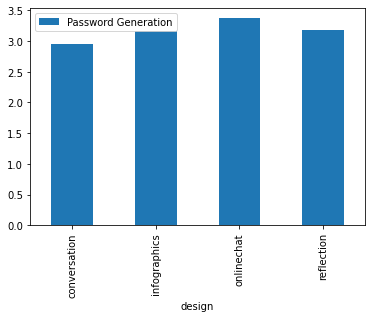

In [156]:
_ = pg_prenorm.groupby('design').mean().div(7).mul(5).plot.bar()

In [157]:
password.head()

,Password Strength,Motivation After Design,Hard to Remember,Guessed by Hacker,Guessed by FnF,Stronger than Usual,Helpful,Easy to think memory,Difficult for num&char,Password Generation,Actual Strength,design
0,2,2,2,2,2,2,2,0,2,0.00,3.0,infographics
1,3,3,1,2,3,3,3,3,3,1.50,3.0,conversation
2,2,2,3,3,3,1,1,2,3,2.25,0.0,reflection
3,2,2,0,2,2,1,2,2,2,0.50,1.5,reflection
4,1,0,3,3,3,0,-2,1,1,0.00,-3.0,conversation


In [158]:
len(password_response_df['password2_recall1'].dropna()), len(password_response_df['password2_recall2'].dropna()), len(password_response_df['password2_recall3'].dropna())

(12, 7, 6)

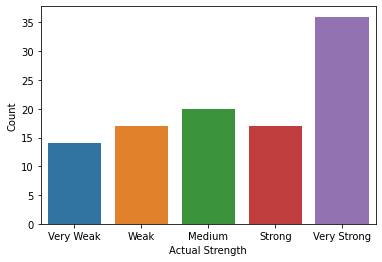

In [159]:
strength_count = password['Actual Strength'].apply(lambda x: list(pass_stmap.keys())[list(pass_stmap.values()).index(x)]).value_counts().rename_axis("Actual Strength").reset_index(name="Count")
_ = sns.barplot(data=strength_count, x='Actual Strength', y='Count', order=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong'])

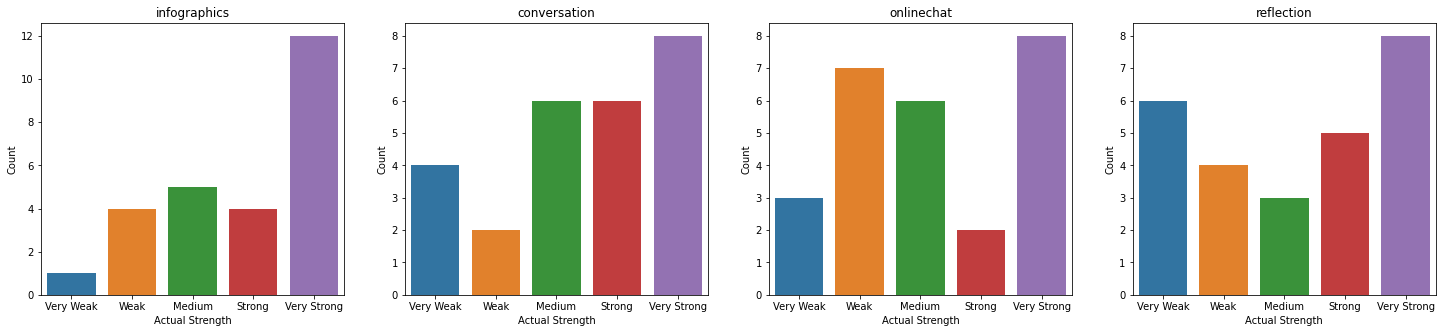

In [160]:
fig, axes = plt.subplots(1, 4,  figsize=(25, 5))
temp = password[['Actual Strength', 'design']]

def get_strength(x):
    return list(pass_stmap.keys())[list(pass_stmap.values()).index(float(x))]


for i, design in enumerate(did_map.values()):
    df = temp[temp['design']==design]['Actual Strength']
    strength_count = df.apply(lambda x: get_strength(x)).value_counts().rename_axis("Actual Strength").reset_index(name="Count")
    sns.barplot(data=strength_count, x='Actual Strength', y='Count', order=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong'], ax= axes[i])
    axes[i].set_title(design)

In [161]:
temp.groupby('design')['Actual Strength'].mean()

design
conversation    0.692308
infographics    1.269231
onlinechat      0.288462
reflection      0.288462
Name: Actual Strength, dtype: float64

In [162]:
test = {}
designs = []
quests = temp.columns.to_list()
quests.remove('design')
for i, param in enumerate(quests):
    test[param] = []
    for design in did_map.values():
        test[param].append(temp[temp['design']==design][param].to_list())
        designs.append(design) if i<=0 else None
# test

In [163]:
# Performing kruskal test
for k, v in test.items():
    print(f'{k}: {kruskal(*v)}')

Actual Strength: KruskalResult(statistic=3.3933987446919125, pvalue=0.3348533888605506)


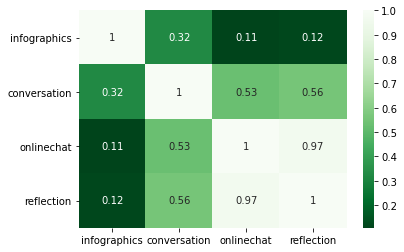

In [164]:
data = sp.posthoc_dunn(test[quests[0]])
data.index = data.index.map(get_design)
data.columns = data.columns.map(get_design)
_ = sns.heatmap(data, annot=True, cmap="Greens_r")